<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_bSSFP_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground/quantified_brain.npz &> /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.9/406.9 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.8/471.8 kB 30.8 MB/s eta 0:00:00


(bSSFP_seq)=

# Imports and definitions

In [2]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [3]:
#@title Define SSFP in PyPulseq
# %% S2. DEFINE the sequence

def seq_bssfp(FAex=60, P_alpha_half=True, TR_ms=0, PEtype='linear', PE_flag=True, TI=0,
              Nread = 64, Nphase= 64,fov = 200e-3,slice_thickness = 8e-3
):
    """
    Create a balanced SSFP sequence with the given parameters.

    Parameters:
    -----------
    FAex : float
        Excitation flip angle in degrees (default: 60)
    P_alpha_half : bool
        Whether to use alpha/2 preparation pulse (default: True)
    TR_ms : float
        Repetition time in milliseconds (default: 0, will use minimum TR)
    PEtype : str
        Phase encoding type: 'linear' or 'centric' (default: 'linear')
    PE_flag : bool
        Whether to enable phase encoding (default: True)
    TI : float
        Inversion time in seconds (default: 0)
    Nread : int
        Number of readouts (default: 64)
    Nphase : int
        Number of phase encoding steps (default: 64)
    fov : float
        Field of view in meters (default: 200e-3)

    Returns:
    --------
    seq : pypulseq.Sequence
        The created sequence object
    """

    TR = TR_ms * 1e-3

    # choose the scanner limits
    system = pp.Opts(max_grad=40,grad_unit='mT/m',max_slew=150,slew_unit='T/m/s', rf_ringdown_time=20e-6,rf_dead_time=100e-6,adc_dead_time=20e-6,grad_raster_time=10e-6)

    seq = pp.Sequence(system)



    # rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)

    fastest_grad = pp.make_extended_trapezoid_area(area=(Nphase)/fov, channel='y', grad_end=0.0, grad_start=0.0, system=system)
    min_gr_dur=fastest_grad[0].shape_dur  # this is a first speedup test, in shoudl run with area=(Nphase/2)/fov, but only area=(Nphase)/fov worked

    dwell=3e-05

    # Define other gradients and ADC events
    gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=dwell*Nread, system=system)
    adc = pp.make_adc(num_samples=Nread, duration=dwell*Nread, phase_offset=0 * np.pi/180, delay=gx.rise_time, system=system)
    gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=min_gr_dur, system=system)
    gp = pp.make_trapezoid(channel='y', area=1, duration=min_gr_dur, system=system)

    rf_phase = 0

    # Define rf events
    rf_IR= pp.make_block_pulse(
        flip_angle=  180* np.pi / 180, phase_offset=90* np.pi / 180, duration=0.5e-3, system=system)
    gz_spoil = pp.make_trapezoid(channel='z',area=64, duration=1e-3, system=system)

    rfdur=0.8e-3
    rf1, gz1, gzr1 = pp.make_sinc_pulse(
      flip_angle=FAex * np.pi / 180, duration=rfdur,
      slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
      system=system, return_gz=True)

    rf0, gz0, gzr0 = pp.make_sinc_pulse(
      flip_angle=FAex/2* np.pi / 180, duration=rfdur,
      slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
      system=system, return_gz=True)

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    ##linear reordering
    phenc = np.arange(-Nphase // 2, Nphase // 2, 1) / fov
    permvec =np.arange(0, Nphase, 1)
    ## centric reordering
    if PEtype=='centric':
      permvec = sorted(np.arange(len(phenc)), key=lambda x: abs(len(phenc) // 2 - x))
    ## random reordering
    #perm =np.arange(0, Nphase, 1);  permvec = np.random.permutation(perm)

    phenc_centr = phenc[permvec] *PE_flag

    ktraj=np.array([])
    if TI>0:
      seq.add_block(rf_IR)
      seq.add_block(gz_spoil)
      seq.add_block(pp.make_delay(TI))

    seq.add_block(pp.make_delay(0.0015-(rfdur/2+rf1.delay)))

    minTR=pp.calc_duration(gz1) + pp.calc_duration(gx_pre,gp,gzr1)+pp.calc_duration(gx)+pp.calc_duration(gp,gx_pre,gzr1)
    minTR2=minTR/2
    TRd=round(max(0, (TR/2-minTR2))/10e-5)*10e-5  # round to raster time
    TR=2*(minTR2 +TRd)
    if TRd==0:
      print('rep. time set to minTR [ms]',TR*1000)
    else:
      print(' TR [ms]', TR*1000)

    if P_alpha_half:
      seq.add_block(rf0,gz0)
      seq.add_block(gzr0)
      # last timing step is to add TR/2 between alpha half and first rf pulse
      # from pulse top to pulse top we have already played out one full gz0 and 2*gzr0, thus we substract these from TR
      seq.add_block(pp.make_delay(minTR2+TRd-pp.calc_duration(gz0)-2*pp.calc_duration(gzr0)))   #  for balancing Gz is played out twice!
      seq.add_block(gzr0)  #  balance Gz!
    for ii in range(0, Nphase):  # e.g. -64:63

        rf_phase = divmod(rf_phase + 180, 360.0)[1]
        rf1.phase_offset = rf_phase / 180 * np.pi   # set current rf phase, 180° alternating phase cycling
        adc.phase_offset = rf_phase / 180 * np.pi  # follow with ADC

        ktraj=np.append(ktraj,phenc_centr[ii])
        seq.add_block(rf1,gz1)
        gp = pp.make_trapezoid(channel='y', area=phenc_centr[ii], duration=min_gr_dur, system=system)
        seq.add_block(pp.make_delay(TRd))

        seq.add_block(gx_pre, gp,gzr1)
        seq.add_block(adc, gx)
        gp = pp.make_trapezoid(channel='y', area=-phenc_centr[ii], duration=min_gr_dur, system=system)
        seq.add_block(gx_pre, gp,gzr1)  #  balance Gz!
        seq.add_block(pp.make_delay(TRd))
        # full pulse            delay of rf2 -ringdown rf1  + TR_delay + RO/2

    seq.set_definition('FOV', [fov, fov, slice_thickness])
    seq.set_definition('ktraj', ktraj)
    return seq


/tmp/ipython-input-3-1867077543.py:62: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf_IR= pp.make_block_pulse(
/tmp/ipython-input-3-1867077543.py:67: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, gz1, gzr1 = pp.make_sinc_pulse(
/tmp/ipython-input-3-1867077543.py:72: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf0, gz0, gzr0 = pp.make_sinc_pulse(


rep. time set to minTR [ms] 3.9
Timing check passed successfully


'a219d6f68bfbf804c6d9bb6d55b5755e'

/tmp/ipython-input-3-1867077543.py:62: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf_IR= pp.make_block_pulse(
/tmp/ipython-input-3-1867077543.py:67: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, gz1, gzr1 = pp.make_sinc_pulse(
/tmp/ipython-input-3-1867077543.py:72: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf0, gz0, gzr0 = pp.make_sinc_pulse(


rep. time set to minTR [ms] 3.9
Timing check passed successfully


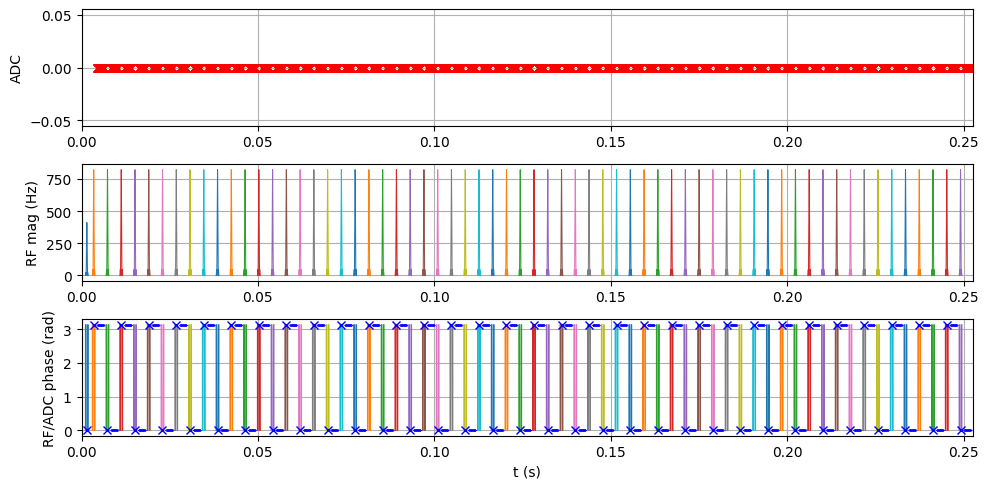

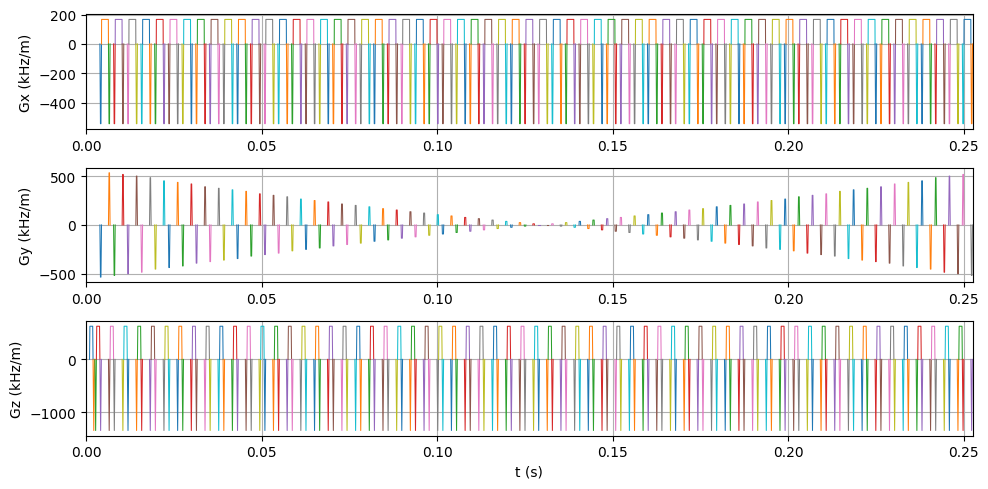

In [4]:
# Parameter definitions with Colab comments
FAex =60  #@param {type: "slider", min: 1, max: 180}
P_alpha_half= True #@param {type: "boolean"}
TR_ms =  0 #@param {type: "slider", min: 0.0, max: 20, step:0.1}
TR=TR_ms*1e-3
PEtype='linear'  #@param ['centric', 'linear']
PE_flag= True #@param {type: "boolean"}
TI =  0 #@param {type: "slider", min: 0, max: 5, step:0.1}
Nread = 64 #@param {type: "slider", min: 1, max: 128, step:1}
Nphase = 64 #@param {type: "slider", min: 1, max: 128, step:1}
fov = 200e-3 #@param {type: "slider", min: 100e-3, max: 500e-3, step:10e-3}

# Create sequence with the defined parameters
seq = seq_bssfp(FAex=FAex, P_alpha_half=P_alpha_half, TR_ms=TR_ms, PEtype=PEtype, PE_flag=PE_flag, TI=TI, Nread=Nread, Nphase=Nphase, fov=fov, slice_thickness=8e-3)

#%% S3. CHECK, PLOT and WRITE the sequence  as .seq
#Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
   print('Timing check passed successfully')
else:
   print('Timing check failed. Error listing follows:')
   [print(e) for e in error_report]

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [200e-3, 200e-3, 8e-3])
seq.write('external.seq')

seq.plot(time_range=(0,1))

# RUNs

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


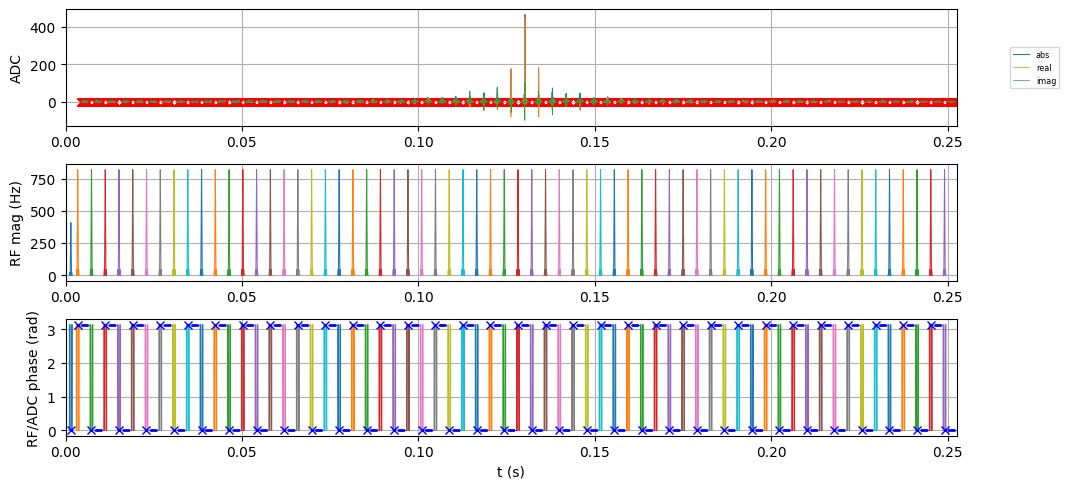

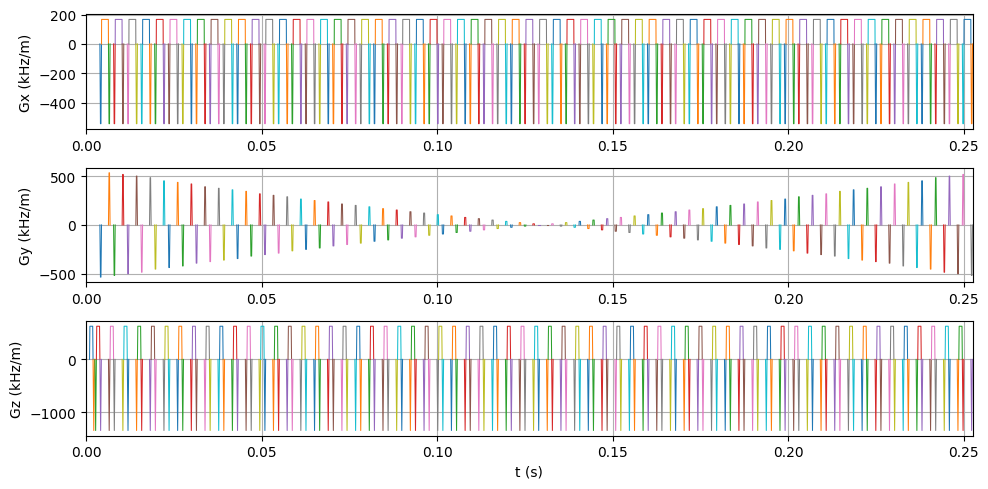

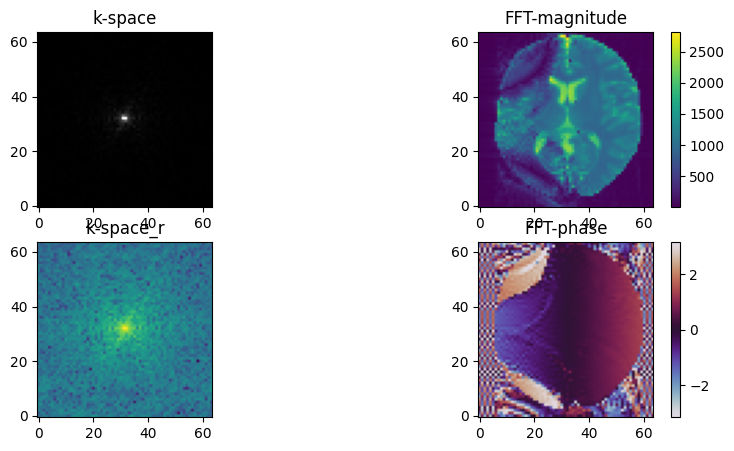

In [5]:
#@title S3 quick 2D brain phantom sim and plot
#signal = mr0.util.simulate_2d(seq)
# signal   = mr0.util.simulate_2d(seq,B0_scale=2, B0_polynomial=(0,0,-150,0,0,300))
#seq.plot(plot_now=False,time_range=(0,2.5*TE))
data = mr0.util.load_phantom(size=(64, 64), dB0_fB0=(0, 2), B0_polynomial=[0, 0, -150, 0, 0, 300])
signal, _ = mr0.util.simulate(seq, data)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal=signal.numpy())
# Get figure handles
fig_handles = plt.get_fignums()

# Iterate and save each figure
for fig_num in fig_handles:
    plt.figure(fig_num)
    plt.savefig(f'bssfp_seq_{fig_num}.png', format='png')

plt.show()

# %% S4: MR IMAGE RECON of signal ::: #####################################
kspace_adc = torch.reshape(signal, (Nphase, Nread)).clone().t()
ktraj=seq.get_definition('ktraj')
permvec=np.argsort(ktraj)
kspace=kspace_adc[:,permvec]
# fftshift,FFT,fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(221)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()), cmap="gray")
plt.subplot(223)
plt.title('k-space_r')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(222)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(224)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi, cmap="twilight")
plt.colorbar()



In [6]:
import time


acc_array = [0.6, 0.5, 0.4, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.00001]
dt= np.zeros(len(acc_array))

space_3d = np.zeros((len(acc_array), Nread, Nphase), dtype=np.complex128)  # Adjust dimensions if needed

for i, acc in enumerate(acc_array):
    t0 = time.time()
    signal, _ = mr0.util.simulate(seq, data, accuracy=acc)
    t1 = time.time()
    dt[i] = t1 - t0

    kspace_adc = torch.reshape(signal, (Nphase, Nread)).T.clone()
    kspace=kspace_adc[:, np.argsort(ktraj)]
    # fftshift,FFT,fftshift
    space = torch.fft.ifftshift(torch.fft.fft2(torch.fft.fftshift(kspace)))
    space_3d[i] = space.numpy()  # Assuming 'space' is a PyTorch tensor
    print(f"Iteration {i + 1} with accuracy {acc:.6f} completed.")

print("All iterations finished. Data stored in 'space_3d'.")

plt.show()

Iteration 1 with accuracy 0.600000 completed.
Iteration 2 with accuracy 0.500000 completed.
Iteration 3 with accuracy 0.400000 completed.
Iteration 4 with accuracy 0.200000 completed.
Iteration 5 with accuracy 0.100000 completed.
Iteration 6 with accuracy 0.050000 completed.
Iteration 7 with accuracy 0.020000 completed.
Iteration 8 with accuracy 0.010000 completed.
Iteration 9 with accuracy 0.005000 completed.
Iteration 10 with accuracy 0.001000 completed.
Iteration 11 with accuracy 0.000010 completed.
All iterations finished. Data stored in 'space_3d'.


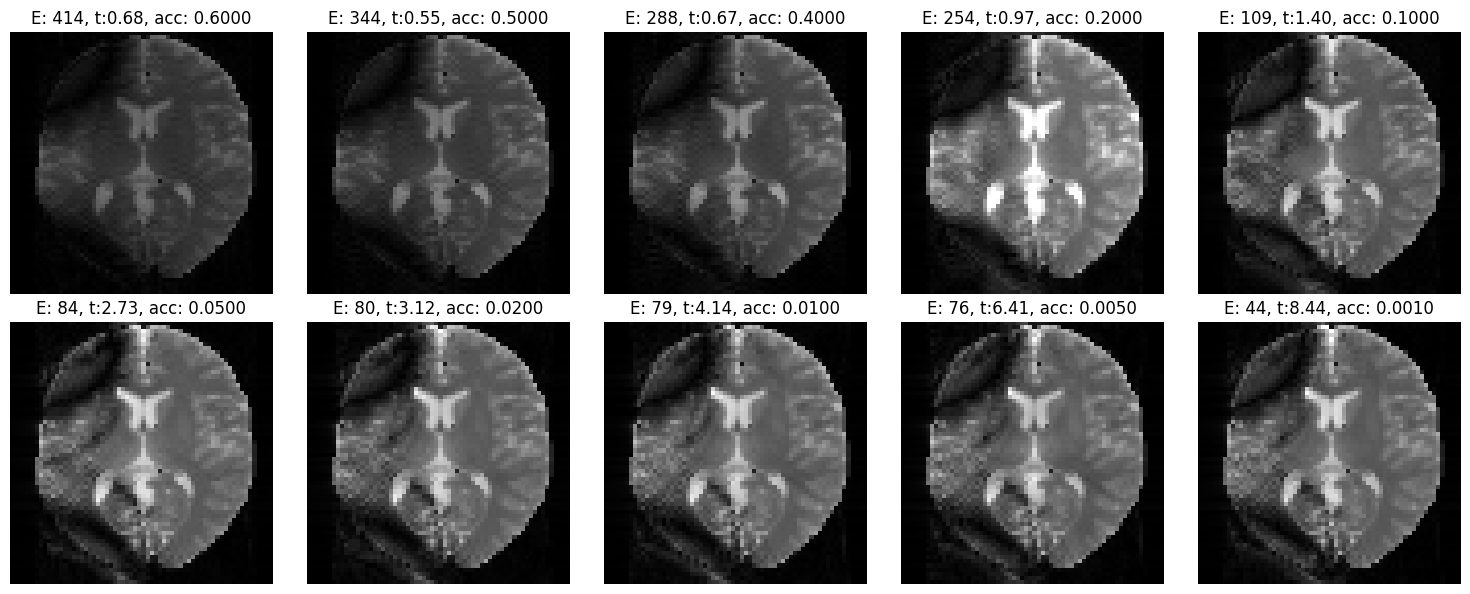

In [7]:

fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns for 10 images
axes = axes.flatten()  # Flatten to a 1D array for easy iteration

# Assuming 'space_3d' is your 3D array of complex images
reference_image = np.abs(space_3d[-1])  # Last image as reference
vmax = np.max(np.abs(reference_image))

for i, ax in enumerate(axes):
    image = np.abs(space_3d[i])  # Absolute value of the current image
    rmse = np.sqrt(np.mean((image - reference_image)**2))  # Calculate RMSE
    ax.imshow(image.T, origin="lower",cmap='gray', vmax=vmax)
    ax.set_title(f"E: {rmse:.0f}, t:{dt[i]:.2f}, acc: {acc_array[i]:.4f}")
    ax.axis('off')


plt.tight_layout()


### Compare to existing reference

The next code just compares the outcome for different accuracies with a reference acquired in feb 2025 on CPU!

Data accuracies should be zero.

run time can vary, for the highest accuracy time discrepancy of ~(0.6511 %) was found in out test.

In [8]:
!wget https://github.com/MRsources/MRzero-Core/raw/refs/heads/main/documentation/playground_mr0/reference_bssfp_data_feb2025.npz &> /dev/null

if 0: # code used for storing the reference
  import os
  import numpy as np
  # Create directory if it doesn't exist
  data_to_save = {"space_3d": space_3d,"dt": dt, "acc_array":np.array(acc_array) }
  np.savez("reference_bssfp_data_feb2025.npz", **data_to_save)

if 1: # get stored reference
  with np.load('reference_bssfp_data_feb2025.npz') as data:
    space_3d_ref = data['space_3d']
    dt_ref = data['dt']
    acc_array_ref = data['acc_array']

print("Acc. \tMag_nrmse\tPhase_nrmse\ttnow \ttref \t(dt[s,%])")
for ii in range(len(acc_array)):

    # Compute absolute magnitude RMSE for space vs. space_wget
    abs_space_error = np.sqrt(np.mean((np.abs(space_3d[ii]) - np.abs(space_3d_ref[ii])) ** 2)) /np.mean(np.abs(space_3d[ii]))

    # Compute phase RMSE for space vs. space_wget
    phase_space_error = np.sqrt(np.mean((np.angle(space_3d[ii]) - np.angle(space_3d_ref[ii])) ** 2))

    # Compute RMSE for dt vs. dt_wget as direct difference
    e_dt_s = (dt[ii] - dt_ref[ii])
    e_dt_r = abs((dt[ii] - dt_ref[ii])) / dt_ref[ii] *100

    #print(f"Acc: {acc_array[ii]:.5f} -> Mag_rmse: {abs_space_error:.4f}, Phase_rmse: {phase_space_error:.4f}, run time: {e_dt:.4f}")
    print(f"{acc_array[ii]:.5f}\t{abs_space_error:.4f}\t\t{phase_space_error:.4f}\t\t{dt[ii] :.3f}s\t{dt_ref[ii] :.3f}s\t{e_dt_s:2.4f} ({e_dt_r:.4f} %)")


Acc. 	Mag_nrmse	Phase_nrmse	tnow 	tref 	(dt[s,%])
0.60000	0.0000		0.0000		0.676s	0.775s	-0.0990 (12.7755 %)
0.50000	0.0000		0.0000		0.549s	0.900s	-0.3516 (39.0587 %)
0.40000	0.0000		0.0000		0.674s	1.044s	-0.3699 (35.4325 %)
0.20000	0.0000		0.0000		0.967s	1.130s	-0.1627 (14.4059 %)
0.10000	0.0000		0.0000		1.397s	1.538s	-0.1415 (9.2001 %)
0.05000	0.0000		0.0000		2.728s	2.236s	0.4925 (22.0310 %)
0.02000	0.0000		0.0000		3.120s	3.439s	-0.3194 (9.2875 %)
0.01000	0.0000		0.0000		4.142s	5.112s	-0.9704 (18.9831 %)
0.00500	0.0000		0.0000		6.409s	5.800s	0.6089 (10.4983 %)
0.00100	0.0000		0.0000		8.439s	9.740s	-1.3009 (13.3559 %)
0.00001	0.0000		0.0000		13.156s	13.918s	-0.7619 (5.4738 %)
